# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Building a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
import pickle
import numpy as np
import random
import cv2
import numpy as np
import matplotlib as mpl
import pandas as pd
mpl.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
from scipy import misc
from scipy.ndimage import rotate
from skimage import transform
from skimage.transform import warp, SimilarityTransform, AffineTransform
from skimage import exposure
from sklearn.utils import shuffle
%matplotlib inline

# Load pickled data
training_file = 'traffic-signs-data/train.p'
validation_file= 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

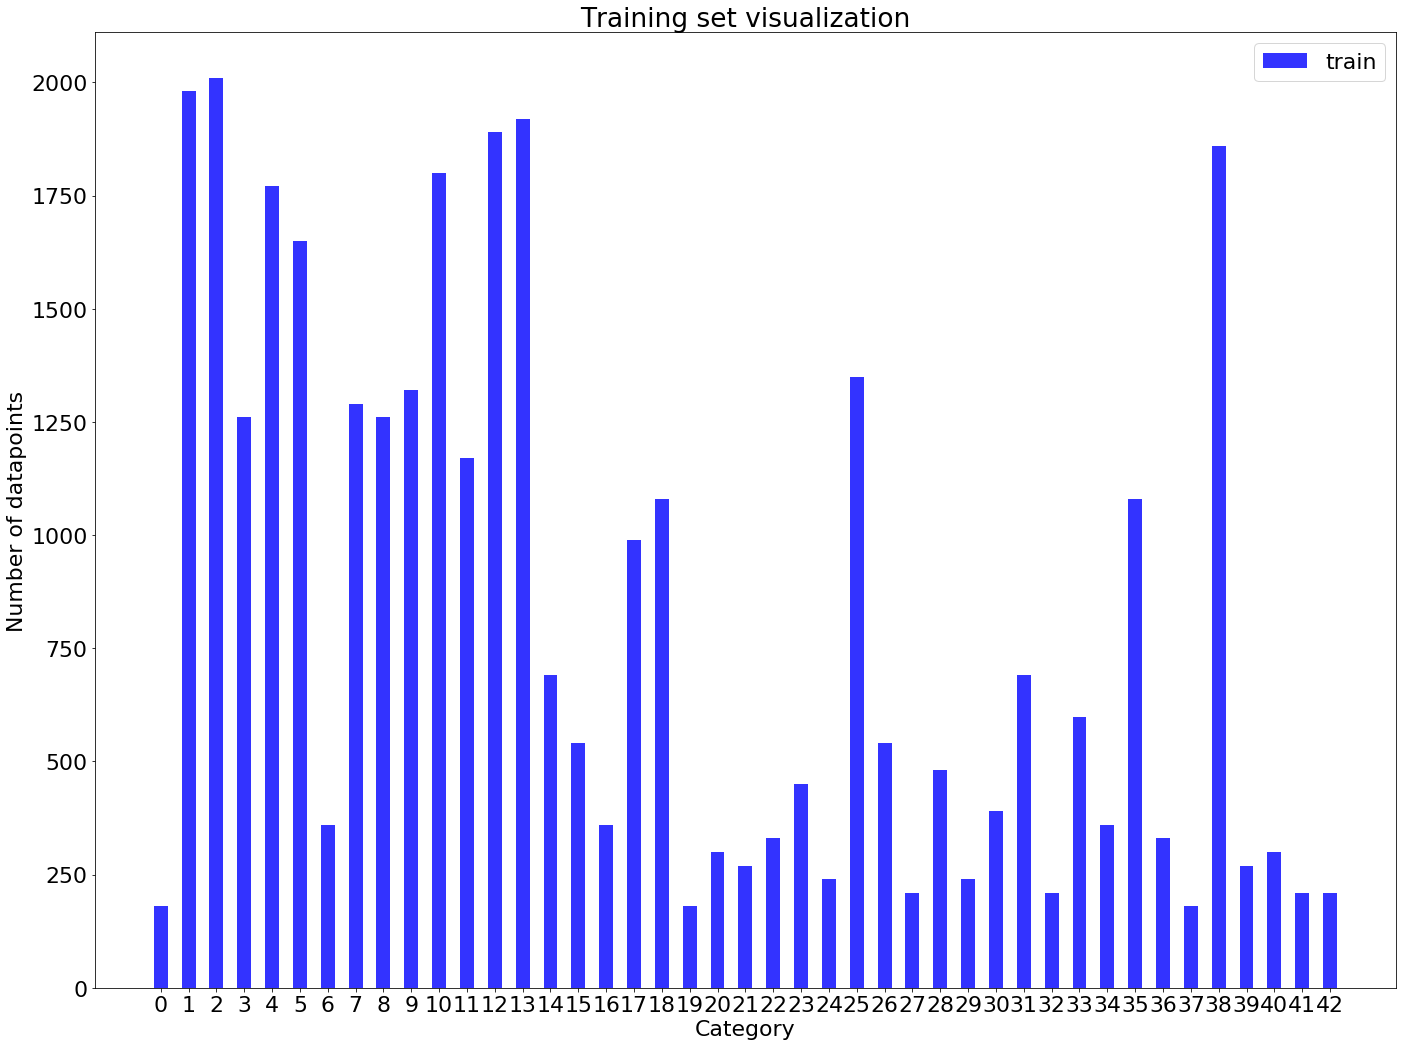

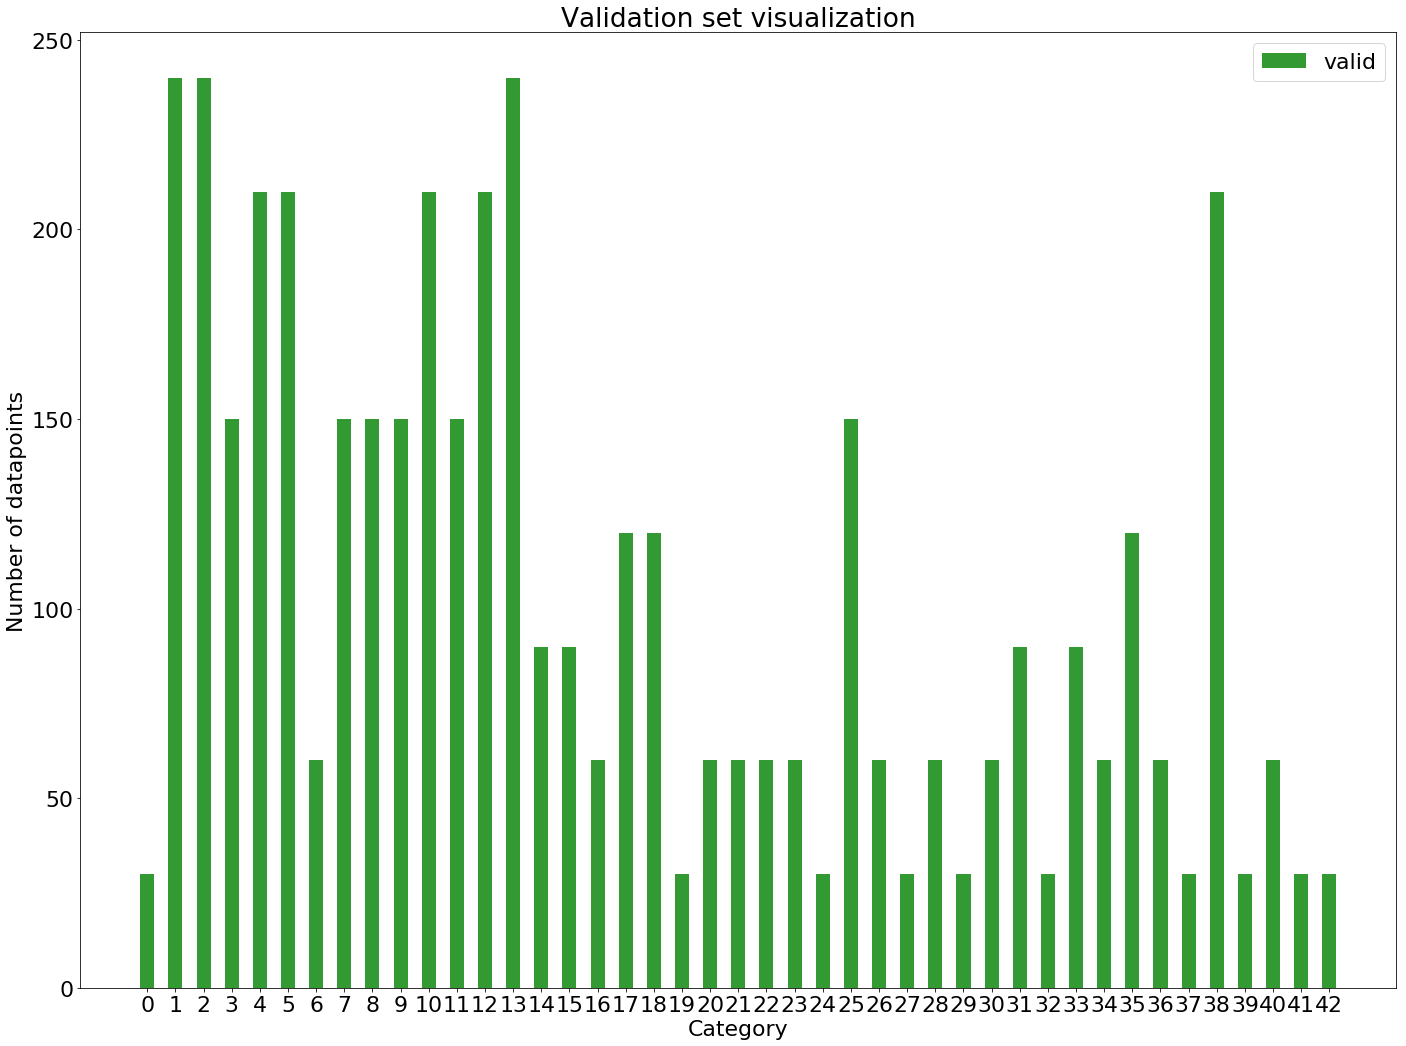

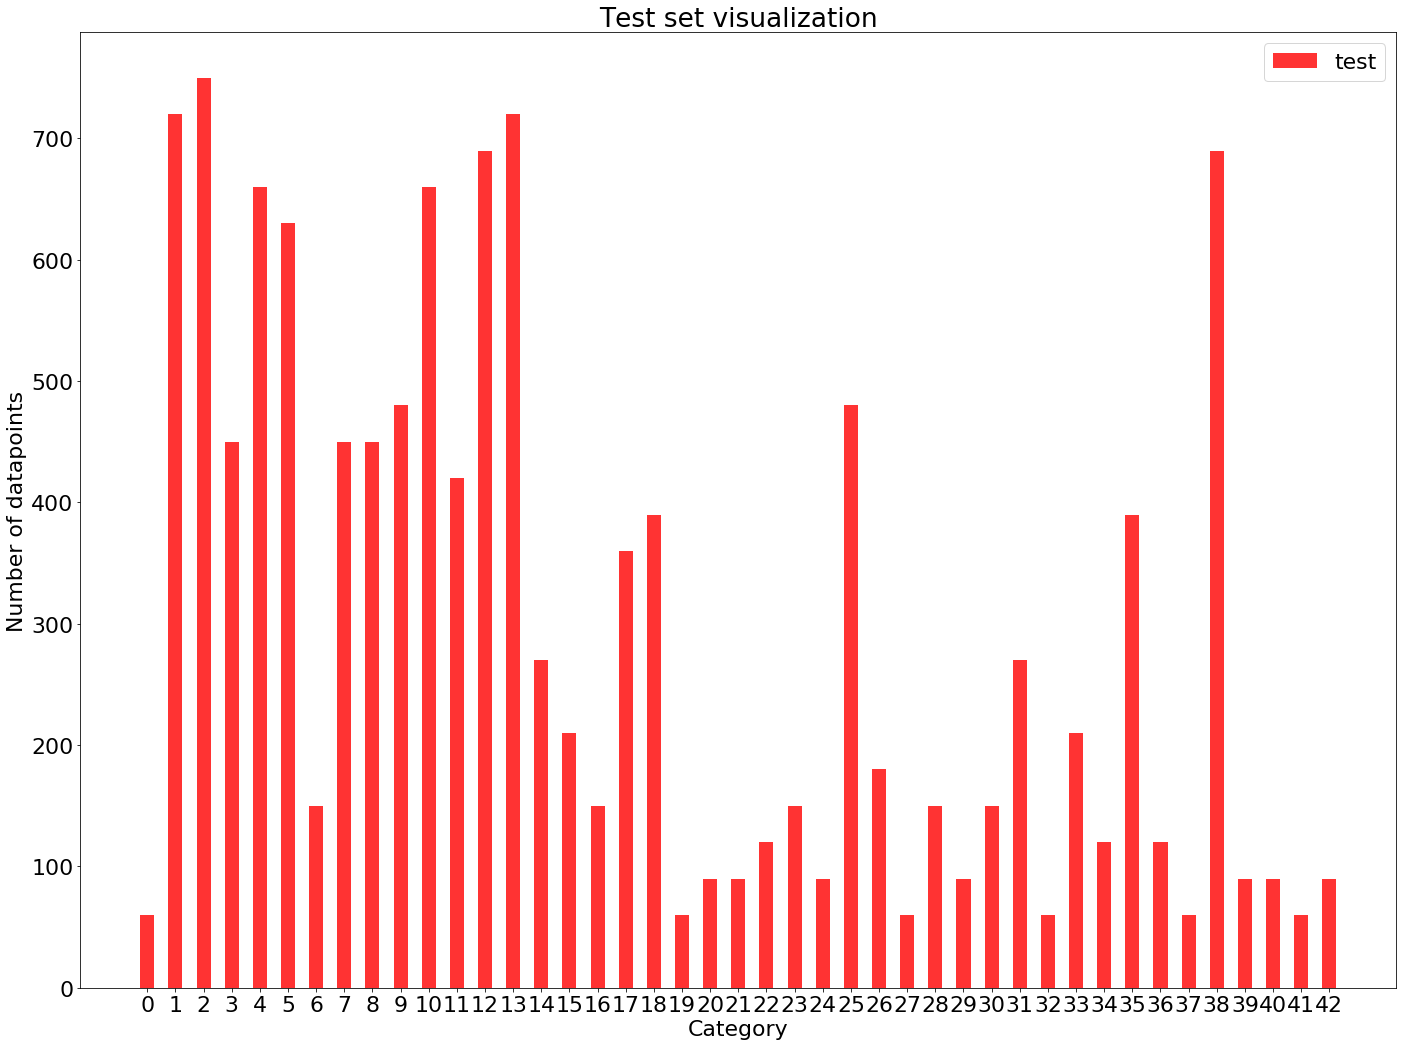

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
# Visualizations will be shown in the notebook.
label_train, count_train = np.unique(np.array(y_train), return_counts=True)
label_valid, count_valid = np.unique(np.array(y_valid), return_counts=True)
label_test, count_test = np.unique(np.array(y_test), return_counts=True)
plt.rcParams.update({'font.size': 22}) 
# create plot
fig, ax = plt.subplots(figsize = (20,15))
index = np.arange(n_classes)
bar_width = 0.5
opacity = 0.8
 
rects1 = plt.bar(index, count_train, bar_width, alpha = opacity, color = 'b', label = 'train')

plt.xlabel('Category')
plt.ylabel('Number of datapoints')
plt.title('Training set visualization')
plt.xticks(index, label_train)
plt.legend()
 
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize = (20,15))
index = np.arange(n_classes)
bar_width = 0.5
opacity = 0.8
 
rects2 = plt.bar(index, count_valid, bar_width, alpha = opacity, color='g', label='valid')
 
plt.xlabel('Category')
plt.ylabel('Number of datapoints')
plt.title('Validation set visualization')
plt.xticks(index, label_train)
plt.legend()
 
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize = (20,15))
index = np.arange(n_classes)
bar_width = 0.5
opacity = 0.8
 
rects3 = plt.bar(index, count_test, bar_width, alpha = opacity, color='r', label='test')
 
plt.xlabel('Category')
plt.ylabel('Number of datapoints')
plt.title('Test set visualization')
plt.xticks(index, label_train)
plt.legend()
 
plt.tight_layout()
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

### Data Augmentation is performed to make the data available in each category equal

### Required functions for data augmentation are declared here

In [4]:
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE()
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    c = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return c.astype(np.uint8)

def apply_rotation(img):
    rotated = 255*transform.rotate(img, angle=np.random.uniform(-15, 15), mode='edge')
    rotated = rotated.astype(np.uint8)
    return rotated.astype(np.uint8)

def apply_translation(img):
    translated = 255*warp(img, transform.SimilarityTransform(translation=(np.random.uniform(-5, 5), np.random.uniform(-5, 5))),mode='edge')
    translated = translated.astype(np.uint8)
    return translated.astype(np.uint8)

def modify_brightness(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    rand = 0.5+random.random()/2
    hsv[:,:,2] = hsv[:,:,2] * rand
    ret = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return ret.astype(np.uint8)

def gaussianblur(img):
    ret = cv2.GaussianBlur(img,(5,5),0)
    return ret.astype(np.uint8)

def medianblur(img):
    ret = cv2.medianBlur(img,5)
    return ret.astype(np.uint8)
    
def augment1(img, k):
    if(k == 1):
        return apply_rotation(apply_translation(img))
    if(k == 2):
        return apply_clahe(apply_rotation(img))
    if(k == 3):
        return modify_brightness(apply_translation(img))
    if(k == 4):
        return modify_brightness(apply_rotation(img))
    if(k == 5):
        return modify_brightness(apply_clahe(img))
    if(k == 6):
        return apply_clahe(apply_translation(img))
    if(k == 7):
        return apply_rotation(img)
    if(k == 8):
        return apply_translation(img)

def augment2(img, k):
    if(k == 1):
        return medianblur(apply_translation(img))
    if(k == 2):
        return gaussianblur(apply_translation(img))
    if(k == 3):
        return medianblur(apply_rotation(img))
    if(k == 4):
        return gaussianblur(apply_rotation(img))

### Data Augmentation is performed below

In [5]:
print('Data augmentation on progress .......')
augment_X = []
augment_y = []

labels, count = np.unique(np.array(y_train), return_counts = True)
for i in range(len(labels)):
    label = labels[i]
    c = count[i]
    if c > 2500:
        continue
    while c < 2500:
        indices = np.where(y_train==label)[0]
        index1 = np.random.choice(indices)
        index2 = np.random.choice(indices)
        rand1 = np.random.randint(1,9)
        rand2 = np.random.randint(1,5)
        augment_X.append(augment1(X_train[index1], rand1))
        augment_X.append(augment2(X_train[index2], rand2))
        augment_y.append(y_train[index1])
        augment_y.append(y_train[index2])
        c += 2

X_train = np.append(X_train, augment_X).reshape(len(X_train)+len(augment_X),32,32,3)
y_train = np.append(y_train, augment_y)

Data augmentation on progress .......


### Images are converted to grayscale and normalized

In [6]:
X_train = np.dot(X_train[:,:,:,0:3],[0.299, 0.587, 0.114]).reshape(len(X_train),32,32,1)
X_valid = np.dot(X_valid[:,:,:,0:3],[0.299, 0.587, 0.114]).reshape(4410,32,32,1)
X_test = np.dot(X_test[:,:,:,0:3],[0.299, 0.587, 0.114]).reshape(12630,32,32,1)

X_train = X_train/128 - 1
X_valid = X_valid/128 - 1
X_test = X_test/128 - 1

n_train = len(X_train)
print("Number of training examples after augmentation=", n_train)

Number of training examples after augmentation= 107501


In [7]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
X_train, y_train = shuffle(X_train, y_train)

EPOCHS = 100
BATCH_SIZE = 256

### Model Architecture

In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.06
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x16.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation
    conv1 = tf.nn.relu(conv1)

    # Pooling: Input = 28x28x16. Output = 14x14x16.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x64.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 64), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(64))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation
    conv2 = tf.nn.relu(conv2)

    # Pooling: Input = 10x10x64. Output = 5x5x64.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten: Input = 5x5x64. Output = 1600.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 1600. Output = 400.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1600, 400), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(400))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation and a dropout with a random keep_prob
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1,random.random())

    # Layer 4: Fully Connected. Input = 400. Output = 200.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(400, 200), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(200))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation and a dropout with a random keep_prob
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2,random.random())

    # Layer 5: Fully Connected. Input = 200. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(200, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [9]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

### Calculate and report the accuracy on the training and validation set.
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

def predict(X_data):
    sess = tf.get_default_session()
    prediction = sess.run(logits, feed_dict = {x: X_data})
    return prediction

Training...

EPOCH 1 ...
Training Accuracy = 0.744
Validation Accuracy = 0.815

EPOCH 2 ...
Training Accuracy = 0.841
Validation Accuracy = 0.873

EPOCH 3 ...
Training Accuracy = 0.880
Validation Accuracy = 0.917

EPOCH 4 ...
Training Accuracy = 0.913
Validation Accuracy = 0.920

EPOCH 5 ...
Training Accuracy = 0.927
Validation Accuracy = 0.930

EPOCH 6 ...
Training Accuracy = 0.933
Validation Accuracy = 0.928

EPOCH 7 ...
Training Accuracy = 0.940
Validation Accuracy = 0.938

EPOCH 8 ...
Training Accuracy = 0.951
Validation Accuracy = 0.944

EPOCH 9 ...
Training Accuracy = 0.953
Validation Accuracy = 0.946

EPOCH 10 ...
Training Accuracy = 0.956
Validation Accuracy = 0.944

EPOCH 11 ...
Training Accuracy = 0.960
Validation Accuracy = 0.951

EPOCH 12 ...
Training Accuracy = 0.966
Validation Accuracy = 0.952

EPOCH 13 ...
Training Accuracy = 0.965
Validation Accuracy = 0.954

EPOCH 14 ...
Training Accuracy = 0.966
Validation Accuracy = 0.958

EPOCH 15 ...
Training Accuracy = 0.965
Valid

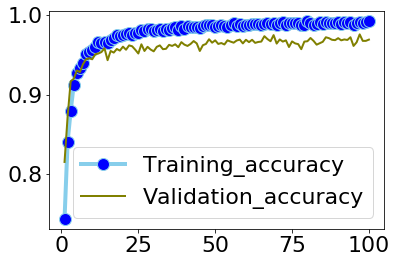

In [10]:
train_accuracy = []
valid_accuracy = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        validation_accuracy = evaluate(X_valid, y_valid)
        training_accuracy = evaluate(X_train, y_train)
        valid_accuracy.append(validation_accuracy)
        train_accuracy.append(training_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    df=pd.DataFrame({'epoch': range(1,101), 'Training_accuracy': train_accuracy, 'Validation_accuracy': valid_accuracy})
    plt.plot( 'epoch', 'Training_accuracy', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
    plt.plot( 'epoch', 'Validation_accuracy', data=df, marker='', color='olive', linewidth=2)
    plt.legend()
    saver.save(sess, './lenet')
    print("Model saved")

In [12]:
### Once a final model architecture is selected,
### the accuracy on the test set should be calculated and reported as well.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
### Feel free to use as many code cells as needed.

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.949


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

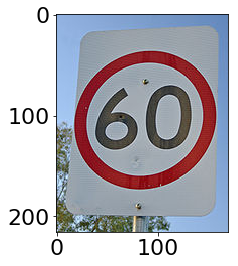

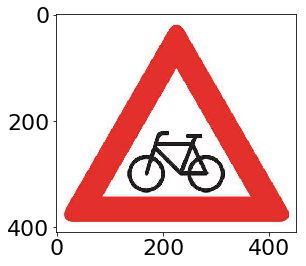

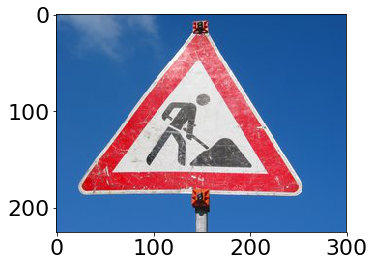

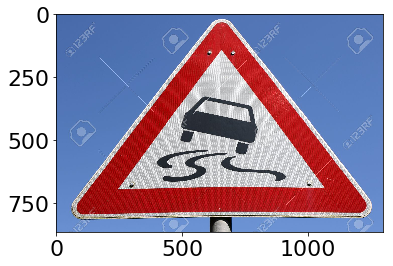

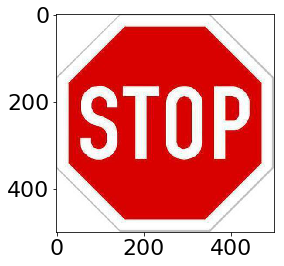

In [33]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
#from PIL import Image
import csv
new_image_files = ['60kmph.jpg', 'bicycles crossing.jpg', 'road work.jpg', 'slippery road.jpg', 'stop sign.jpg']
new_data = np.asarray([3, 29, 25, 23, 14])
new_img = []
i = 0
sign_name = []
with open('signnames.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for sign in reader:
        sign_name.append(sign[1])
    
for fname in new_image_files:
    img = mpimg.imread('traffic-signs-data/'+fname)
    plt.figure()
    plt.imshow(img)
    img = cv2.resize(img, (32, 32))
    img = np.dot(img[:,:,0:3],[0.299, 0.587, 0.114]).reshape(img.shape[0],img.shape[1],1)
    img = img/128 - 1
    new_img.append(np.float32(img))
new_img = np.asarray(new_img)

### Predict the Sign Type for Each Image

In [42]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
accuracy = 0
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    prediction_logits = predict(new_img)
    exp_pred = np.exp(prediction_logits)
    s_pred = np.sum(exp_pred, axis = 1).reshape(5, 1)
    prediction = exp_pred/s_pred
    top5 = sess.run(tf.nn.top_k(tf.constant(prediction), k=5))
    print(top5)
    print()
    print()
    print('Predictions:')
    predictions = top5.indices[:,0]
    accuracy = np.sum(predictions == new_data)
    sign_predictions = []
    for i in range(len(predictions)):
        sign_predictions.append(sign_name[predictions[i]])
    print(sign_predictions)
#     accuracy = evaluate(new_img, new_data)
    accuracy = accuracy*100/5
    print("Test Accuracy = {:.3f}".format(accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
TopKV2(values=array([[9.9997413e-01, 2.5848443e-05, 9.8421395e-09, 1.1457474e-09,
        4.1658558e-14],
       [8.6764300e-01, 1.3235472e-01, 1.4150237e-06, 7.6297027e-07,
        1.5291441e-07],
       [1.0000000e+00, 3.0122097e-31, 3.4051609e-37, 2.1988689e-37,
        2.3117825e-38],
       [9.9993014e-01, 6.9846981e-05, 6.7917446e-14, 7.3785892e-18,
        1.9764532e-18],
       [9.9999994e-01, 9.2678263e-08, 3.9667453e-13, 7.4726344e-14,
        1.8613925e-18]], dtype=float32), indices=array([[ 3,  6,  5, 42,  1],
       [29, 22, 28, 20, 23],
       [25, 22, 23, 20, 31],
       [23, 29, 31, 24, 22],
       [14, 15,  3,  8, 29]], dtype=int32))


Predictions:
['Speed limit (60km/h)', 'Bicycles crossing', 'Road work', 'Slippery road', 'Stop']
Test Accuracy = 100.000


### Analyze Performance

In [43]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
print("New images Accuracy = {:.2f}%".format(accuracy))

New images Accuracy = 100.00%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [44]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
pred = top5.indices
pred_sign_names = []
for i in range(len(pred)):
    pred_sign_names.append([])
    for j in range(len(pred[i])):
        pred_sign_names[i].append(sign_name[pred[i][j]])

In [45]:
for i in range(5):
    print('probabilities on the image '+new_image_files[i][:-4]+':')
    for j in range(5):
        print('probability of the image being '+str(pred_sign_names[i][j])+': {:.3f}'.format(top5.values[i][j]))
    print('')
    print('')
print(top5.values)

probabilities on the image 60kmph:
probability of the image being Speed limit (60km/h): 1.000
probability of the image being End of speed limit (80km/h): 0.000
probability of the image being Speed limit (80km/h): 0.000
probability of the image being End of no passing by vehicles over 3.5 metric tons: 0.000
probability of the image being Speed limit (30km/h): 0.000


probabilities on the image bicycles crossing:
probability of the image being Bicycles crossing: 0.868
probability of the image being Bumpy road: 0.132
probability of the image being Children crossing: 0.000
probability of the image being Dangerous curve to the right: 0.000
probability of the image being Slippery road: 0.000


probabilities on the image road work:
probability of the image being Road work: 1.000
probability of the image being Bumpy road: 0.000
probability of the image being Slippery road: 0.000
probability of the image being Dangerous curve to the right: 0.000
probability of the image being Wild animals cross

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [46]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")